In [134]:
from typing import Callable, Tuple
from IPython.core.display_functions import display
from sklearn.datasets import make_classification, make_moons
import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, RocCurveDisplay, auc, roc_auc_score, f1_score, balanced_accuracy_score
from time import time_ns, time
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
plt.rcParams["figure.figsize"] = (20,10)
random_state = 244827
n_samples = 2427
n_trains = 100

## Klasa na dane

In [125]:
class PUMData:
    def __init__(self, gen, random_state=244827, test_size=0.2):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(gen[0], gen[1], test_size=test_size, random_state=random_state, shuffle=True, stratify=gen[1])
        self.big_x_train, self.small_x_train, self.big_y_train, self.small_y_train = train_test_split(self.x_train, self.y_train, test_size=0.25, random_state=random_state)

    def normalize(self, min_v=0, max_v=1):
        for i in range(self.x_train.shape[1]):
            if self.x_train[:, i].dtype not in [int, float]:
                continue

            x_min = np.min(self.x_train[:, i])
            x_max = np.max(self.x_train[:, i])
            if x_min != x_max:
                self.x_train[:, i] = (self.x_train[:, i] - x_min) / (x_max - x_min)
                self.x_train[:, i] = self.x_train[:, i] * (max_v - min_v) + min_v

                self.small_x_train[:, i] = (self.small_x_train[:, i] - x_min) / (x_max - x_min)
                self.small_x_train[:, i] = self.small_x_train[:, i] * (max_v - min_v) + min_v

                self.big_x_train[:, i] = (self.big_x_train[:, i] - x_min) / (x_max - x_min)
                self.big_x_train[:, i] = self.big_x_train[:, i] * (max_v - min_v) + min_v

                self.x_test[:, i] = (self.x_test[:, i] - x_min) / (x_max - x_min)
                self.x_test[:, i] = self.x_test[:, i] * (max_v - min_v) + min_v
            else:
                self.x_train[:, i] = 1
                self.x_test[:, i] = 1
                self.small_x_train[:, i] = 1
                self.big_x_train[:, i] = 1

    def change_labels(self, old: list, new: list):
        for o, n in zip(old, new):
            self.y_test[self.y_test == o] = n
            self.y_train[self.y_train == o] = n
            self.big_y_train[self.big_y_train == o] = n
            self.small_y_train[self.small_y_train == o] = n

    def winsorize(self):
        for i in range(self.x_train.shape[1]):
            if self.x_train[:, i].dtype not in [int, float] or len(np.unique(self.x_train[:, i])) == 2:
                continue
            q1_train = np.percentile(self.x_train[:, i], 25)
            q3_train = np.percentile(self.x_train[:, i], 75)
            iqr_train = q3_train - q1_train
            self.x_train[:, i] = np.clip(self.x_train[:, i], q1_train - 1.5 * iqr_train, q3_train + 1.5 * iqr_train)

            q1_test = np.percentile(self.x_test[:, i], 25)
            q3_test = np.percentile(self.x_test[:, i], 75)
            iqr_test = q3_test - q1_test
            self.x_test[:, i] = np.clip(self.x_test[:, i], q1_test - 1.5 * iqr_test, q3_test + 1.5 * iqr_test)

            self.big_x_train, self.small_x_train, self.big_y_train, self.small_y_train = train_test_split(self.x_train, self.y_train, test_size=0.25, random_state=random_state)

    def make_polynomial(self, poly_degree=2, include_bias=False):
        self.x_test = PolynomialFeatures(degree=poly_degree, include_bias=include_bias).fit_transform(self.x_test)
        self.x_train = PolynomialFeatures(degree=poly_degree, include_bias=include_bias).fit_transform(self.x_train)

## Klasa Drzewa decyzyjnego oraz pomocnicza klasa do struktury drzewa

In [119]:
class Node:
    def __init__(self, feature: int=None, threshold: float=None, left=None, right=None, prediction=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.prediction = prediction


class MyDecisionTree:
    _accepted_criterions = ['entropy', 'gini']
    def __init__(self, criterion: str= 'entropy', max_depth: int=99, min_samples_split: int=2, probing_splits: int = 20, n_train_feats=None, random_state=None):
        if criterion not in self._accepted_criterions:
            raise ValueError('Loss must be one of {}'.format(self._accepted_criterions))

        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.probing_splits = probing_splits
        self.random_state = random_state
        self.root = None
        self.n_train_feats = n_train_feats
        self.criterion = {'entropy': self._entropy, 'gini': self._gini_index}[criterion]
        self.x_train = None

    @staticmethod
    def _gini_index(y: ndarray) -> float:
        unique_y = np.unique(y)
        gini = 0
        for cls in unique_y:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls ** 2
        return 1 - gini

    @staticmethod
    def _entropy(y: ndarray) -> float:
        unique_y = np.unique(y)
        entropy = 0
        for cls in unique_y:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy


    def _build_tree(self, x_train: ndarray, y_train: ndarray, depth: int = 0) -> Node:
        n, m = x_train.shape
        n_labels = len(np.unique(y_train))

        if depth >= self.max_depth or n_labels == 1 or n < self.min_samples_split:
            value = np.argmax(np.bincount(y_train))
            return Node(prediction=value)

        best_feature, best_threshold = self._best_split(x_train, y_train)

        if best_feature is None:
            value = np.argmax(np.bincount(y_train))
            return Node(prediction=value)

        left = self._build_tree(x_train[x_train[:, best_feature] <= best_threshold], y_train[x_train[:, best_feature] <= best_threshold], depth + 1)
        right = self._build_tree(x_train[x_train[:, best_feature] > best_threshold], y_train[x_train[:, best_feature] > best_threshold], depth + 1)
        return Node(feature=best_feature, threshold=best_threshold, left=left, right=right)


    def _best_split(self, x_train: ndarray, y: ndarray) -> (int, float):
        best_gain = -float('inf')
        best_feature = None
        best_threshold = None

        if self.n_train_feats is None:
            feats = range(x_train.shape[1])
        elif self.n_train_feats == int(self.n_train_feats):
            feats = np.random.choice(range(x_train.shape[1]), self.n_train_feats, replace=False)
        elif 1 > self.n_train_feats > 0:
            feats = np.random.choice(range(x_train.shape[1]), int(self.n_train_feats * x_train.shape[1]), replace=False)
        else:
            raise ValueError('n_train_feats must be int or float between 0 and 1 or None')

        for feat in feats:
            feat_col = x_train[:, feat]
            thrs = np.unique(feat_col)
            if len(thrs) > self.probing_splits:
                resolution = (x_train.max() - x_train.min()) / self.probing_splits
                thrs = np.arange(np.min(x_train) + resolution, np.max(x_train) - resolution, resolution)
            for threshold in thrs:
                info_gain = self._info_gain(feat_col, y, threshold)

                if info_gain > best_gain:
                    best_gain = info_gain
                    best_feature = feat
                    best_threshold = threshold

        if best_gain == 0:
            return None, None

        return best_feature, best_threshold


    def _info_gain(self, x: ndarray, y: ndarray, threshold) -> float:
        org_entropy = self.criterion(y)

        left_idx = np.argwhere(x <= threshold).flatten()
        right_idx = np.argwhere(x > threshold).flatten()

        if len(left_idx) == 0 or len(right_idx) == 0:
            return 0

        n = y.shape[0]
        left_entropy = self.criterion(y[left_idx])
        right_entropy = self.criterion(y[right_idx])
        split_entropy = (len(left_idx) / n) * left_entropy + (len(right_idx) / n) * right_entropy

        return org_entropy - split_entropy

    def _walk_tree(self, node: Node, x: ndarray) -> int:
        if node.prediction is not None:
            return node.prediction

        if x[node.feature] <= node.threshold:
            return self._walk_tree(node.left, x)
        else:
            return self._walk_tree(node.right, x)

    def fit(self, x_train: ndarray, y_train: ndarray):
        self.x_train = x_train
        self.root = self._build_tree(x_train, y_train)
        return self

    def predict(self, x: ndarray) -> ndarray:
        if self.root is None:
            raise ValueError('Tree not fitted')

        return np.array([self._walk_tree(self.root, x_sample) for x_sample in x])

class MyRandomForest:
    def __init__(self, n_estimators: int = 100, criterion: str = 'gini', min_samples_split: int=2, max_depth: int=99, probing_splits: int=20, n_jobs: int=1, n_feats_train: int=None):
        self.n_estimators = n_estimators
        self.criterion = criterion
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.probing_splits = probing_splits
        self.n_train_feats = n_feats_train
        self.n_jobs = n_jobs
        self.estimators = []

    @staticmethod
    def _train_sample(x_train: ndarray, y_train: ndarray) -> (ndarray, ndarray):
        sample_idx = np.random.choice(x_train.shape[0], x_train.shape[0])
        return x_train[sample_idx], y_train[sample_idx]

    def fit(self, x_train: ndarray, y_train: ndarray):
        self.estimators = [MyDecisionTree(criterion=self.criterion, min_samples_split=self.min_samples_split, max_depth=self.max_depth, probing_splits=self.probing_splits, n_train_feats=self.n_train_feats) for _ in range(self.n_estimators)]
        for estimator in self.estimators:
            x_sample, y_sample = self._train_sample(x_train, y_train)
            estimator.fit(x_sample, y_sample)

    def predict(self, x: ndarray) -> ndarray:
        if len(self.estimators) == 0:
            raise ValueError('Tree not fitted')

        preds = np.array([estimator.predict(x) for estimator in self.estimators]).T
        return np.array([np.argmax(np.bincount(pred)) for pred in preds])

## Funkcja do porównywania modeli

In [102]:
def compare_models(my_model, sk_model, data: PUMData):
    x_min, x_max = data.x_test[:, 0].min() - 0.25, data.x_test[:, 0].max() + 0.25
    y_min, y_max = data.x_test[:, 1].min() - 0.25, data.x_test[:, 1].max() + 0.25
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    mesh_data = np.c_[xx.ravel(), yy.ravel()]

    Z_an = my_model.predict(mesh_data).reshape(xx.shape)
    Z_sk = sk_model.predict(mesh_data).reshape(xx.shape)

    f, axarr = plt.subplots(1, 2, sharex="col", sharey="row", figsize=(20, 15))

    for idx, Z, title in zip(
        range(2),
        [Z_an, Z_sk],
        ['Implementacja własna', 'Model DecisionTreeClassifier']):
        axarr[idx].contourf(xx, yy, Z, alpha=0.4, levels=1)
        axarr[idx].scatter(data.x_test[:, 0], data.x_test[:, 1], c=data.y_test, s=20, edgecolor="k")
        axarr[idx].set_title(title)

    plt.show()

    y_an_predicted = my_model.predict(data.x_test)
    y_sk_predicted = sk_model.predict(data.x_test)

    cm_sk = confusion_matrix(data.y_test, y_sk_predicted, labels=[0, 1])
    cm_an = confusion_matrix(data.y_test, y_an_predicted, labels=[0, 1])

    sensitivity_sk = cm_sk[1, 1] / (cm_sk[1, 0] + cm_sk[1, 1])
    specifity_sk = cm_sk[0, 0] / (cm_sk[0, 0] + cm_sk[0, 1])

    sensitivity_an = cm_an[1, 1] / (cm_an[1, 0] + cm_an[1, 1])
    specifity_an = cm_an[0, 0] / (cm_an[0, 0] + cm_an[0, 1])

    print(f'Model własny: Czulość: {sensitivity_an}, swoistość: {specifity_an}, Adjusted accuracy={balanced_accuracy_score(data.y_test, y_an_predicted, adjusted=True)}')
    print(f'Model sklearn: Czulość: {sensitivity_sk}, swoistość: {specifity_sk}, Adjusted accuracy={balanced_accuracy_score(data.y_test, y_sk_predicted, adjusted=True)}')

    f, axarr = plt.subplots(1, 2, sharex="col", sharey="row", figsize=(15, 8))

    for idx, cm, title in zip(
        range(2),
        [cm_an, cm_sk],
        ['Implementacja własna', 'Model DecisionTreeClassifier']
    ):
        sns.heatmap(cm, annot=True, fmt="d", ax=axarr[idx], cmap="Blues")
        axarr[idx].set_title(title)

    plt.show()

## Generacja danych

In [109]:
single_mod_data = PUMData(make_classification(n_samples=n_samples, n_features=2, n_redundant=0, n_classes=2, n_clusters_per_class=1, random_state=random_state), random_state=random_state)

In [110]:
dual_mod_data = PUMData(make_classification(n_samples=n_samples, n_features=2, n_redundant=0, n_classes=2, n_clusters_per_class=2, random_state=random_state), random_state=random_state)

## Trening na danych jednomodowych z nieograniczoną (teoretycznie) głębokością drzewa

In [135]:
start = time()
for _ in range(n_trains):
    my_model = MyRandomForest(criterion='gini')
    my_model.fit(single_mod_data.x_train, single_mod_data.y_train)
print(f'Average time for {n_trains} trains: {(time() - start) / n_trains}')

Average time for 100 trains: 13.214901978969573


In [136]:
start = time()
for _ in range(n_trains):
    sk_model = RandomForestClassifier(criterion='gini')
    sk_model.fit(single_mod_data.x_train, single_mod_data.y_train)
print(f'Average time for {n_trains} trains: {(time() - start) / n_trains}')

Average time for 100 trains: 0.13118860483169556


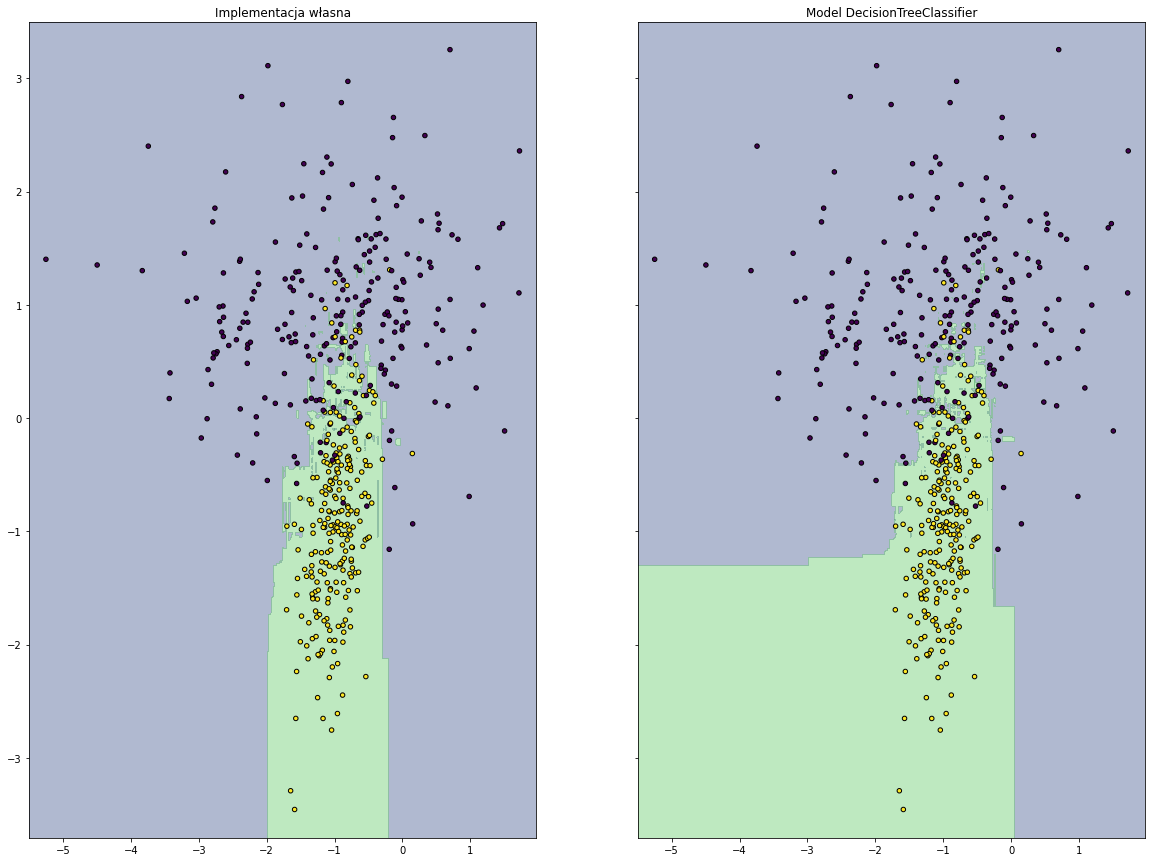

Model własny: Czulość: 0.9057377049180327, swoistość: 0.9049586776859504, Adjusted accuracy=0.8106963826039832
Model sklearn: Czulość: 0.9180327868852459, swoistość: 0.9049586776859504, Adjusted accuracy=0.8229914645711962


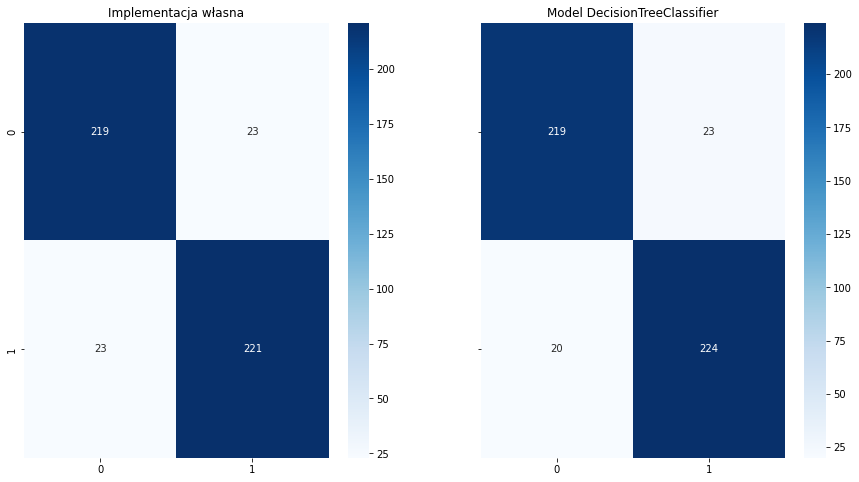

In [137]:
compare_models(my_model, sk_model, single_mod_data)

## Trening na danych dwumodowych z nieograniczoną (teoretycznie) głębokością drzewa

In [138]:
start = time()
for _ in range(n_trains):
    my_model = MyRandomForest(criterion='gini')
    my_model.fit(dual_mod_data.x_train, dual_mod_data.y_train)
print(f'Average time for {n_trains} trains: {(time() - start) / n_trains}')

Average time for 100 trains: 14.390545642375946


In [139]:
start = time()
for _ in range(n_trains):
    sk_model = RandomForestClassifier(criterion='gini')
    sk_model.fit(dual_mod_data.x_train, dual_mod_data.y_train)
print(f'Average time for {n_trains} trains: {(time() - start) / n_trains}')

Average time for 100 trains: 0.13174181938171386


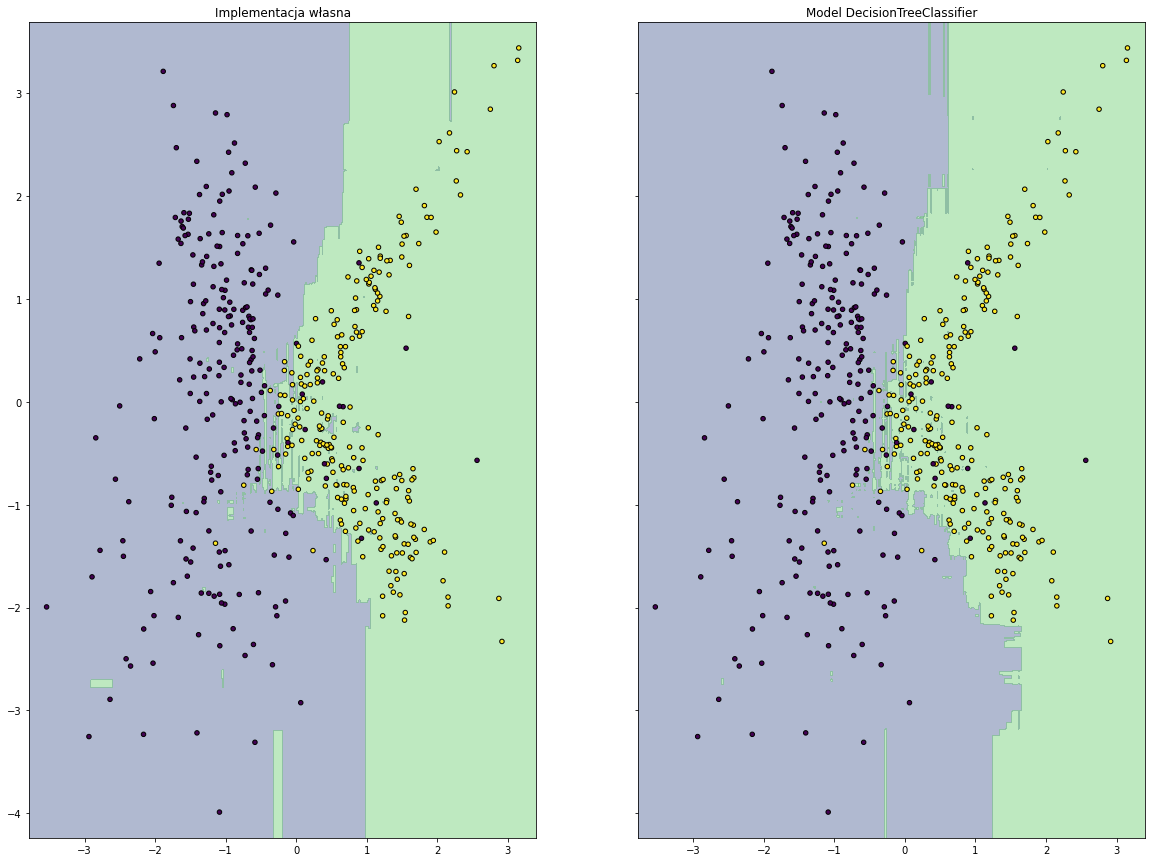

Model własny: Czulość: 0.930327868852459, swoistość: 0.9256198347107438, Adjusted accuracy=0.8559477035632028
Model sklearn: Czulość: 0.9508196721311475, swoistość: 0.9256198347107438, Adjusted accuracy=0.8764395068418913


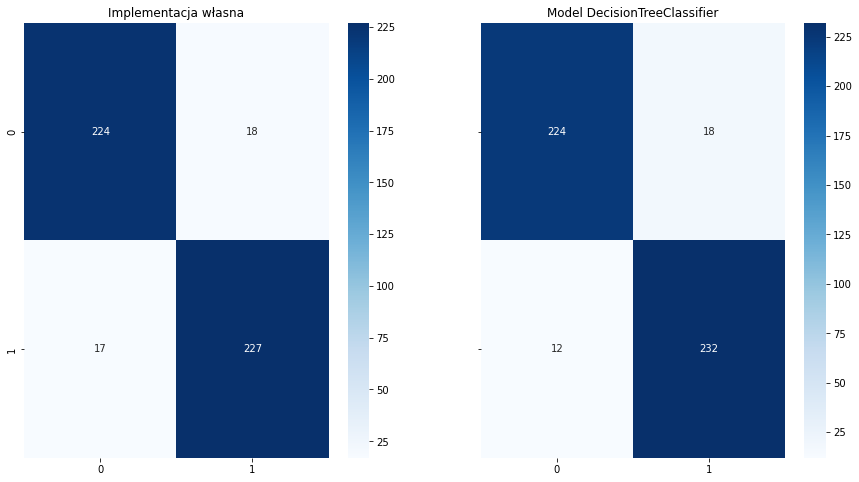

In [140]:
compare_models(my_model, sk_model, dual_mod_data)

## Trening na danych jednomodowych z ograniczoną do ilości cech głębokością drzewa

In [141]:
start = time()
for _ in range(n_trains):
    my_model = MyRandomForest(criterion='gini', max_depth=single_mod_data.x_train.shape[1])
    my_model.fit(single_mod_data.x_train, single_mod_data.y_train)
print(f'Average time for {n_trains} trains: {(time() - start) / n_trains}')

Average time for 100 trains: 0.8945793104171753


In [142]:
start = time()
for _ in range(n_trains):
    sk_model = RandomForestClassifier(criterion='gini', max_depth=single_mod_data.x_train.shape[1])
    sk_model.fit(single_mod_data.x_train, single_mod_data.y_train)
print(f'Average time for {n_trains} trains: {(time() - start) / n_trains}')

Average time for 100 trains: 0.0900239610671997


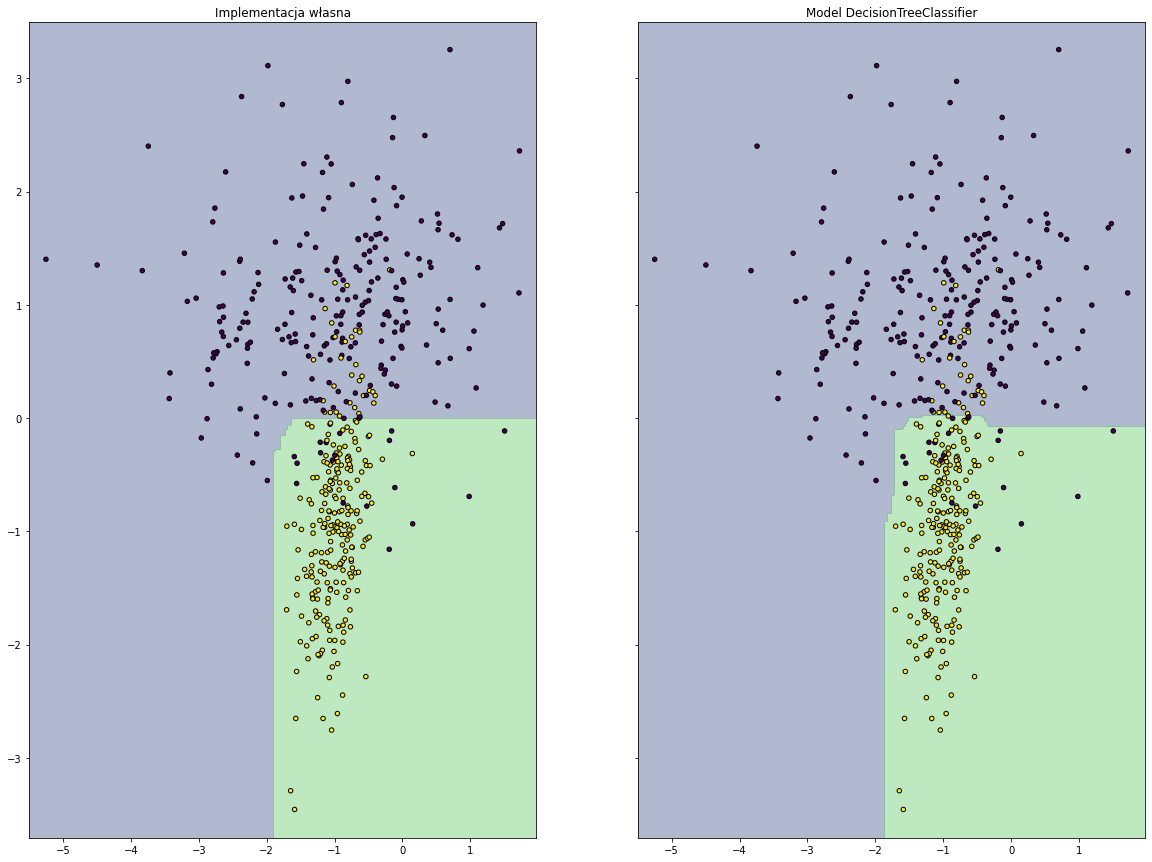

Model własny: Czulość: 0.8729508196721312, swoistość: 0.9132231404958677, Adjusted accuracy=0.7861739601679989
Model sklearn: Czulość: 0.8729508196721312, swoistość: 0.9090909090909091, Adjusted accuracy=0.7820417287630401


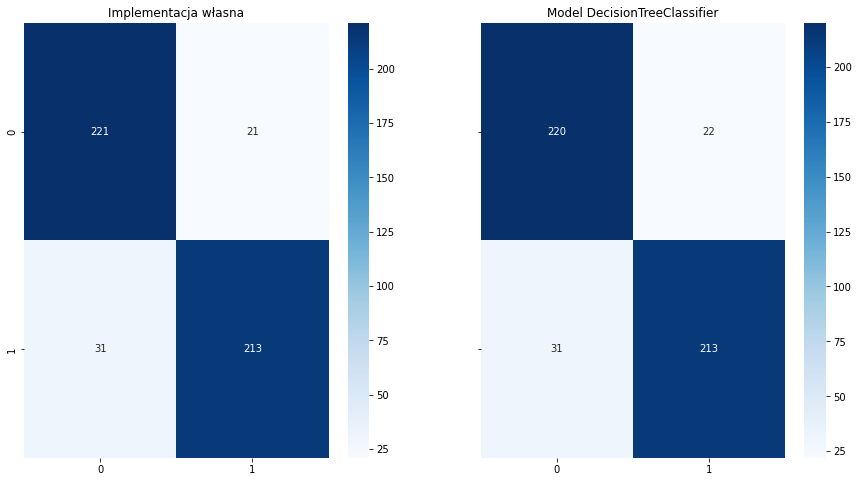

In [143]:
compare_models(my_model, sk_model, single_mod_data)

## Trening na danych wielomodowych z ograniczoną do ilości cech głębokością drzewa

In [144]:
start = time()
for _ in range(n_trains):
    my_model = MyRandomForest(criterion='gini', max_depth=single_mod_data.x_train.shape[1])
    my_model.fit(dual_mod_data.x_train, dual_mod_data.y_train)
print(f'Average time for {n_trains} trains: {(time() - start) / n_trains}')

Average time for 100 trains: 0.9455033326148987


In [145]:
start = time()
for _ in range(n_trains):
    sk_model = RandomForestClassifier(criterion='gini', max_depth=single_mod_data.x_train.shape[1])
    sk_model.fit(dual_mod_data.x_train, dual_mod_data.y_train)
print(f'Average time for {n_trains} trains: {(time() - start) / n_trains}')

Average time for 100 trains: 0.09027098655700684


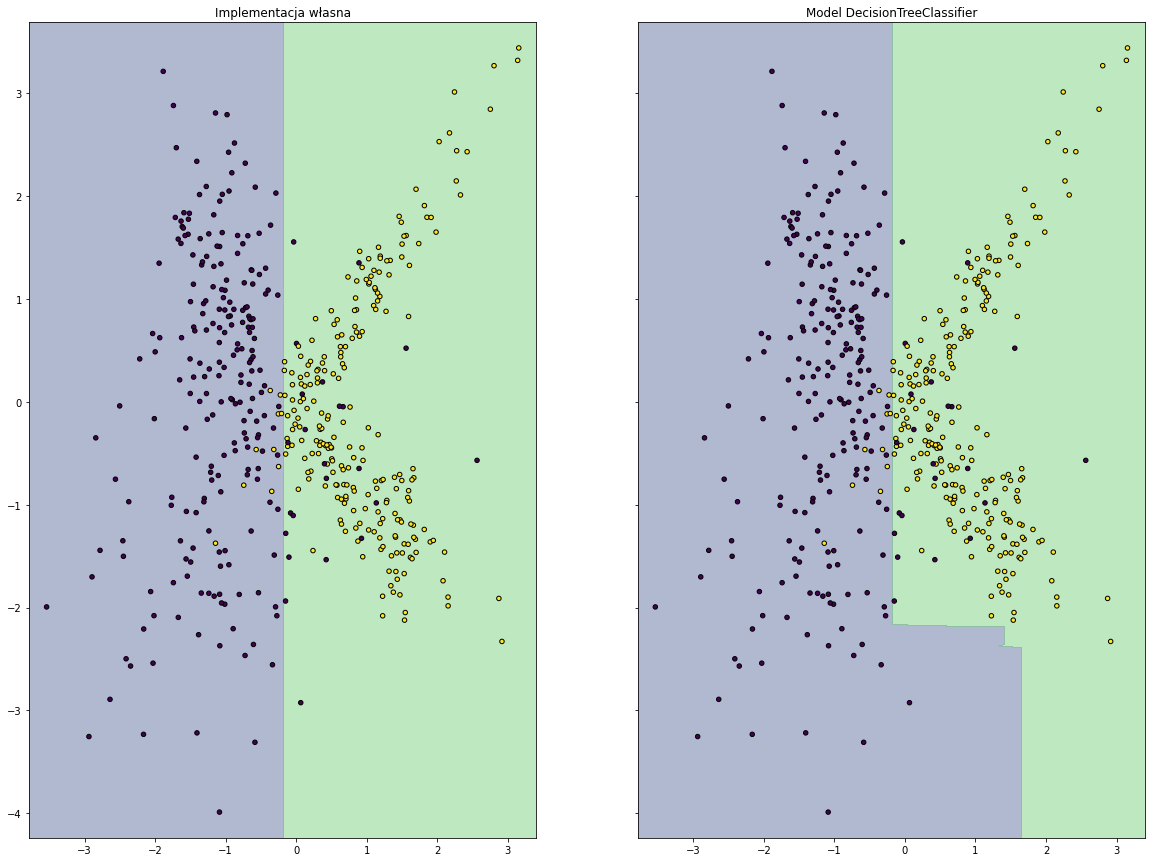

Model własny: Czulość: 0.9590163934426229, swoistość: 0.9049586776859504, Adjusted accuracy=0.8639750711285732
Model sklearn: Czulość: 0.9590163934426229, swoistość: 0.9090909090909091, Adjusted accuracy=0.868107302533532


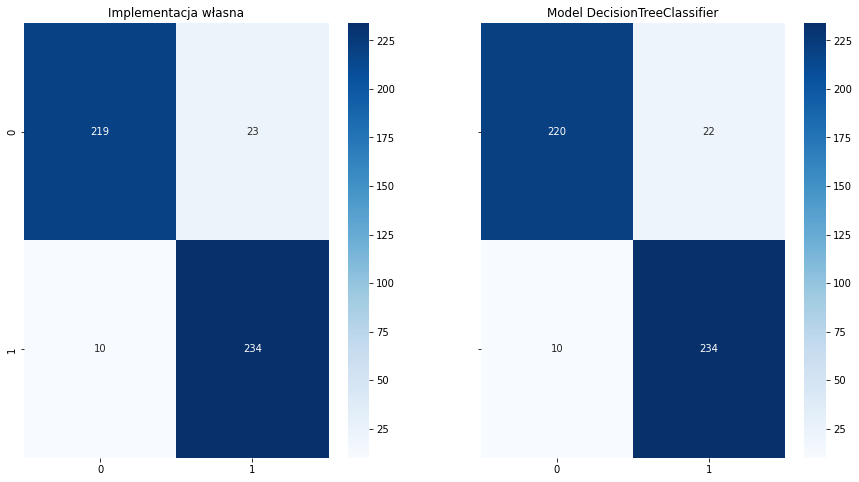

In [146]:
compare_models(my_model, sk_model, dual_mod_data)

## Trening na danych jednomodowych z ograniczoną do ilości klastrów głębokością drzewa

In [147]:
start = time()
for _ in range(n_trains):
    my_model = MyRandomForest(criterion='gini', max_depth=2)
    my_model.fit(single_mod_data.x_train, single_mod_data.y_train)
print(f'Average time for {n_trains} trains: {(time() - start) / n_trains}')

Average time for 100 trains: 0.896636004447937


In [148]:
start = time()
for _ in range(n_trains):
    sk_model = RandomForestClassifier(criterion='gini', max_depth=2)
    sk_model.fit(single_mod_data.x_train, single_mod_data.y_train)
print(f'Average time for {n_trains} trains: {(time() - start) / n_trains}')

Average time for 100 trains: 0.09005012512207031


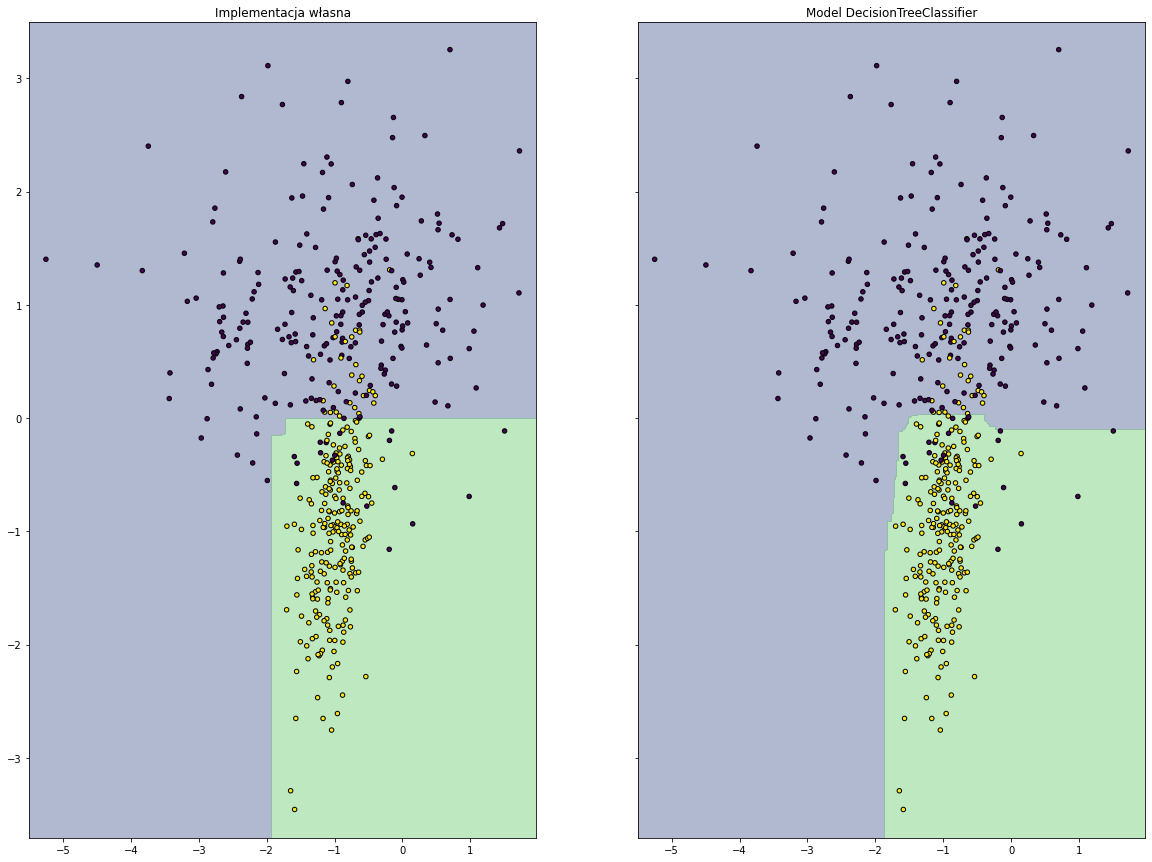

Model własny: Czulość: 0.8729508196721312, swoistość: 0.9132231404958677, Adjusted accuracy=0.7861739601679989
Model sklearn: Czulość: 0.8770491803278688, swoistość: 0.9090909090909091, Adjusted accuracy=0.7861400894187778


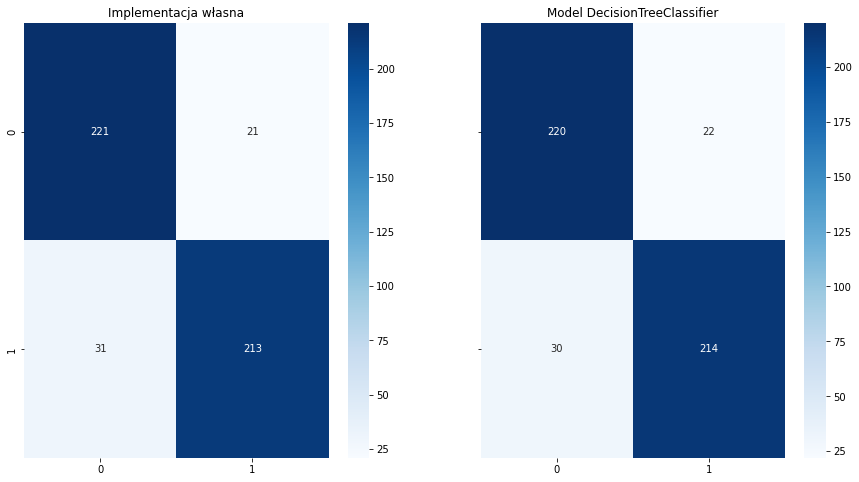

In [149]:
compare_models(my_model, sk_model, single_mod_data)

## Trening na danych wielomodowych z ograniczoną do ilości klastrów głębokością drzewa

In [150]:
start = time()
for _ in range(n_trains):
    my_model = MyRandomForest(criterion='gini', max_depth=4)
    my_model.fit(dual_mod_data.x_train, dual_mod_data.y_train)
print(f'Average time for {n_trains} trains: {(time() - start) / n_trains}')

Average time for 100 trains: 2.6683839917182923


In [151]:
start = time()
for _ in range(n_trains):
    sk_model = RandomForestClassifier(criterion='gini', max_depth=4)
    sk_model.fit(dual_mod_data.x_train, dual_mod_data.y_train)
print(f'Average time for {n_trains} trains: {(time() - start) / n_trains}')

Average time for 100 trains: 0.10458479404449463


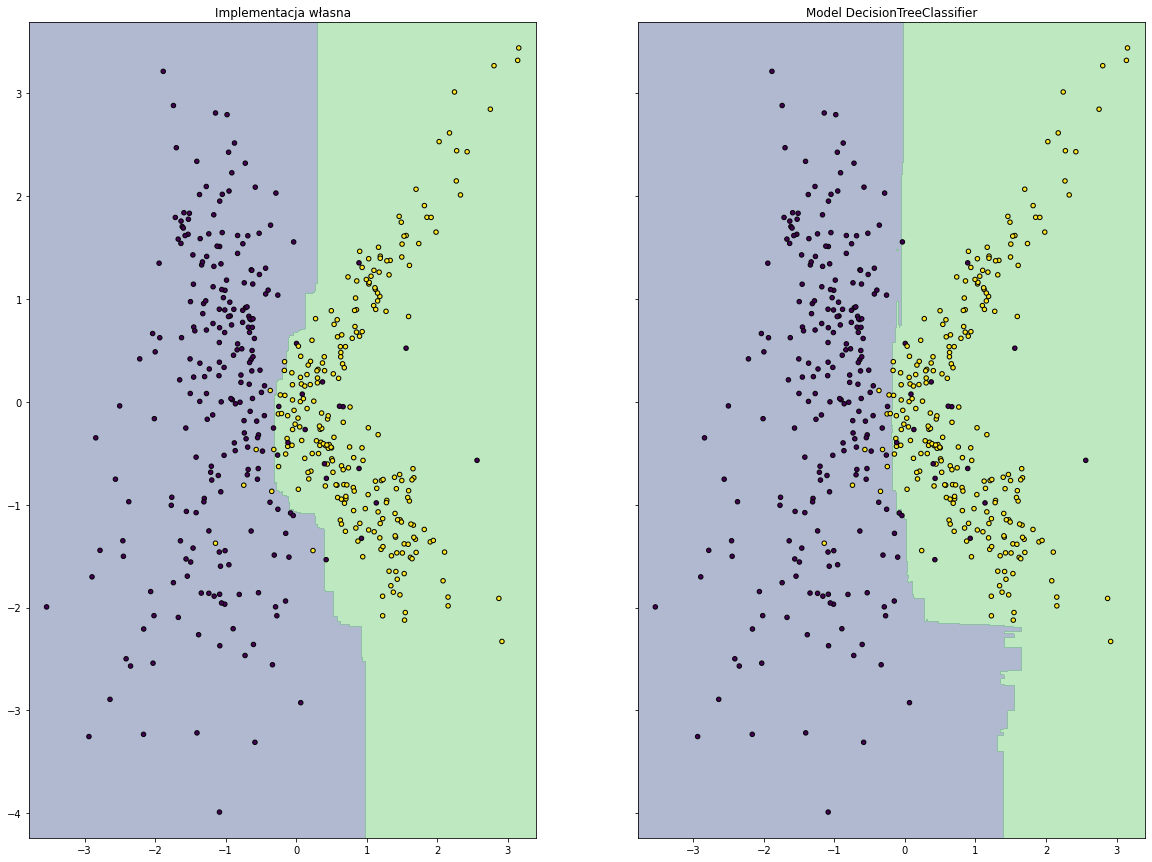

Model własny: Czulość: 0.9631147540983607, swoistość: 0.9256198347107438, Adjusted accuracy=0.8887345888091045
Model sklearn: Czulość: 0.9590163934426229, swoistość: 0.9297520661157025, Adjusted accuracy=0.8887684595583254


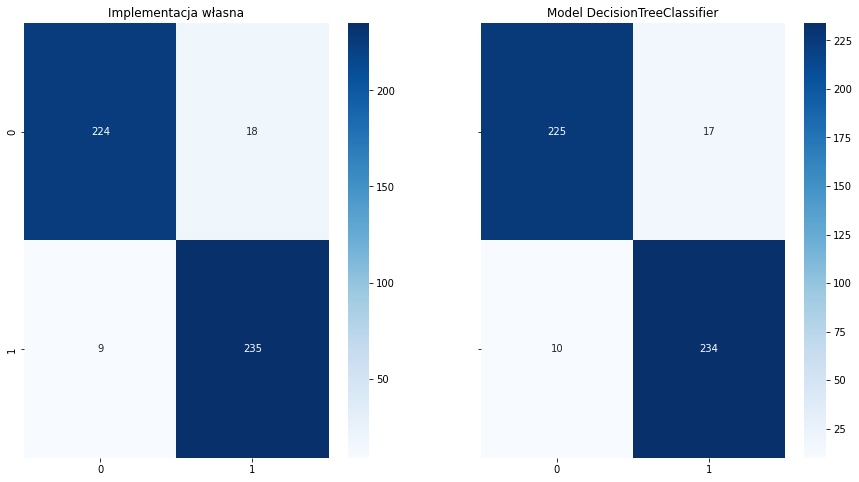

In [152]:
compare_models(my_model, sk_model, dual_mod_data)

# Czesc na 4

In [44]:
pd.options.display.max_columns = 999
nasaDF = pd.read_csv('NASA_JPL_asteroid.csv', low_memory=False)
print(nasaDF.shape)
display(nasaDF.head(5))
nasaDF = nasaDF.loc[:, nasaDF.isin(['NaN', np.NaN]).mean() < .3]
nasaDF = nasaDF.reset_index(drop=True)
print(nasaDF.shape)
display(nasaDF.head(5))

(958524, 45)


,id,spkid,full_name,pdes,name,prefix,neo,pha,H,diameter,albedo,diameter_sigma,orbit_id,epoch,epoch_mjd,epoch_cal,equinox,e,a,q,i,om,w,ma,ad,n,tp,tp_cal,per,per_y,moid,moid_ld,sigma_e,sigma_a,sigma_q,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,class,rms
0,a0000001,2000001,1 Ceres,1,Ceres,NaN,N,N,3.40,939.400,0.0900,0.200,JPL 47,2458600.5,58600,20190427.0,J2000,0.076009,2.769165,2.558684,10.594067,80.305531,73.597695,77.372098,2.979647,0.213885,2.458239e+06,2.018043e+07,1683.145703,4.608202,1.59478,620.640533,4.819000e-12,1.032800e-11,1.956900e-11,4.608900e-09,6.168800e-08,6.624800e-08,7.820700e-09,1.111300e-11,1.196500e-12,3.782900e-08,9.415900e-09,MBA,0.43301
1,a0000002,2000002,2 Pallas,2,Pallas,NaN,N,N,4.20,545.000,0.1010,18.000,JPL 37,2459000.5,59000,20200531.0,J2000,0.229972,2.773841,2.135935,34.832932,173.024741,310.202392,144.975675,3.411748,0.213345,2.458321e+06,2.018072e+07,1687.410992,4.619880,1.23429,480.348639,3.193400e-08,4.033700e-09,8.832200e-08,3.469400e-06,6.272400e-06,9.128200e-06,8.859100e-06,4.961300e-09,4.653600e-10,4.078700e-05,3.680700e-06,MBA,0.35936
2,a0000003,2000003,3 Juno,3,Juno,NaN,N,N,5.33,246.596,0.2140,10.594,JPL 112,2459000.5,59000,20200531.0,J2000,0.256936,2.668285,1.982706,12.991043,169.851482,248.066193,125.435355,3.353865,0.226129,2.458446e+06,2.018112e+07,1592.013769,4.358696,1.03429,402.514639,3.052000e-08,3.471800e-09,8.139200e-08,3.223100e-06,1.664600e-05,1.772100e-05,8.110400e-06,4.363900e-09,4.413400e-10,3.528800e-05,3.107200e-06,MBA,0.33848
3,a0000004,2000004,4 Vesta,4,Vesta,NaN,N,N,3.00,525.400,0.4228,0.200,JPL 35,2458600.5,58600,20190427.0,J2000,0.088721,2.361418,2.151909,7.141771,103.810804,150.728541,95.861938,2.570926,0.271609,2.458248e+06,2.018051e+07,1325.432763,3.628837,1.13948,443.451432,2.332100e-10,1.514300e-09,1.928600e-09,2.170600e-07,3.880800e-07,1.789300e-07,1.206800e-06,1.648600e-09,2.612500e-10,4.103700e-06,1.274900e-06,MBA,0.39980
4,a0000005,2000005,5 Astraea,5,Astraea,NaN,N,N,6.90,106.699,0.2740,3.140,JPL 114,2459000.5,59000,20200531.0,J2000,0.190913,2.574037,2.082619,5.367427,141.571026,358.648418,17.846343,3.065455,0.238661,2.458926e+06,2.020032e+07,1508.414421,4.129814,1.09575,426.433027,2.373700e-08,3.970900e-09,6.092400e-08,2.740800e-06,2.894900e-05,2.984200e-05,8.303800e-06,4.729000e-09,5.522700e-10,3.474300e-05,3.490500e-06,MBA,0.52191


(958524, 40)


,id,spkid,full_name,pdes,neo,pha,H,orbit_id,epoch,epoch_mjd,epoch_cal,equinox,e,a,q,i,om,w,ma,ad,n,tp,tp_cal,per,per_y,moid,moid_ld,sigma_e,sigma_a,sigma_q,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,class,rms
0,a0000001,2000001,1 Ceres,1,N,N,3.40,JPL 47,2458600.5,58600,20190427.0,J2000,0.076009,2.769165,2.558684,10.594067,80.305531,73.597695,77.372098,2.979647,0.213885,2.458239e+06,2.018043e+07,1683.145703,4.608202,1.59478,620.640533,4.819000e-12,1.032800e-11,1.956900e-11,4.608900e-09,6.168800e-08,6.624800e-08,7.820700e-09,1.111300e-11,1.196500e-12,3.782900e-08,9.415900e-09,MBA,0.43301
1,a0000002,2000002,2 Pallas,2,N,N,4.20,JPL 37,2459000.5,59000,20200531.0,J2000,0.229972,2.773841,2.135935,34.832932,173.024741,310.202392,144.975675,3.411748,0.213345,2.458321e+06,2.018072e+07,1687.410992,4.619880,1.23429,480.348639,3.193400e-08,4.033700e-09,8.832200e-08,3.469400e-06,6.272400e-06,9.128200e-06,8.859100e-06,4.961300e-09,4.653600e-10,4.078700e-05,3.680700e-06,MBA,0.35936
2,a0000003,2000003,3 Juno,3,N,N,5.33,JPL 112,2459000.5,59000,20200531.0,J2000,0.256936,2.668285,1.982706,12.991043,169.851482,248.066193,125.435355,3.353865,0.226129,2.458446e+06,2.018112e+07,1592.013769,4.358696,1.03429,402.514639,3.052000e-08,3.471800e-09,8.139200e-08,3.223100e-06,1.664600e-05,1.772100e-05,8.110400e-06,4.363900e-09,4.413400e-10,3.528800e-05,3.107200e-06,MBA,0.33848
3,a0000004,2000004,4 Vesta,4,N,N,3.00,JPL 35,2458600.5,58600,20190427.0,J2000,0.088721,2.361418,2.151909,7.141771,103.810804,150.728541,95.861938,2.570926,0.271609,2.458248e+06,2.018051e+07,1325.432763,3.628837,1.13948,443.451432,2.332100e-10,1.514300e-09,1.928600e-09,2.170600e-07,3.880800e-07,1.789300e-07,1.206800e-06,1.648600e-09,2.612500e-10,4.103700e-06,1.274900e-06,MBA,0.39980
4,a0000005,2000005,5 Astraea,5,N,N,6.90,JPL 114,2459000.5,59000,20200531.0,J2000,0.190913,2.574037,2.082619,5.367427,141.571026,358.648418,17.846343,3.065455,0.238661,2.458926e+06,2.020032e+07,1508.414421,4.129814,1.09575,426.433027,2.373700e-08,3.970900e-09,6.092400e-08,2.740800e-06,2.894900e-05,2.984200e-05,8.303800e-06,4.729000e-09,5.522700e-10,3.474300e-05,3.490500e-06,MBA,0.52191


In [45]:
for column in nasaDF.columns:
    if len(nasaDF[column].unique()) == nasaDF.shape[0] or len(nasaDF[column].unique()) == 1:
        print(column)
        nasaDF = nasaDF.drop(column, axis=1)

display(nasaDF.head())

id
spkid
full_name
pdes
equinox


,neo,pha,H,orbit_id,epoch,epoch_mjd,epoch_cal,e,a,q,i,om,w,ma,ad,n,tp,tp_cal,per,per_y,moid,moid_ld,sigma_e,sigma_a,sigma_q,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,class,rms
0,N,N,3.40,JPL 47,2458600.5,58600,20190427.0,0.076009,2.769165,2.558684,10.594067,80.305531,73.597695,77.372098,2.979647,0.213885,2.458239e+06,2.018043e+07,1683.145703,4.608202,1.59478,620.640533,4.819000e-12,1.032800e-11,1.956900e-11,4.608900e-09,6.168800e-08,6.624800e-08,7.820700e-09,1.111300e-11,1.196500e-12,3.782900e-08,9.415900e-09,MBA,0.43301
1,N,N,4.20,JPL 37,2459000.5,59000,20200531.0,0.229972,2.773841,2.135935,34.832932,173.024741,310.202392,144.975675,3.411748,0.213345,2.458321e+06,2.018072e+07,1687.410992,4.619880,1.23429,480.348639,3.193400e-08,4.033700e-09,8.832200e-08,3.469400e-06,6.272400e-06,9.128200e-06,8.859100e-06,4.961300e-09,4.653600e-10,4.078700e-05,3.680700e-06,MBA,0.35936
2,N,N,5.33,JPL 112,2459000.5,59000,20200531.0,0.256936,2.668285,1.982706,12.991043,169.851482,248.066193,125.435355,3.353865,0.226129,2.458446e+06,2.018112e+07,1592.013769,4.358696,1.03429,402.514639,3.052000e-08,3.471800e-09,8.139200e-08,3.223100e-06,1.664600e-05,1.772100e-05,8.110400e-06,4.363900e-09,4.413400e-10,3.528800e-05,3.107200e-06,MBA,0.33848
3,N,N,3.00,JPL 35,2458600.5,58600,20190427.0,0.088721,2.361418,2.151909,7.141771,103.810804,150.728541,95.861938,2.570926,0.271609,2.458248e+06,2.018051e+07,1325.432763,3.628837,1.13948,443.451432,2.332100e-10,1.514300e-09,1.928600e-09,2.170600e-07,3.880800e-07,1.789300e-07,1.206800e-06,1.648600e-09,2.612500e-10,4.103700e-06,1.274900e-06,MBA,0.39980
4,N,N,6.90,JPL 114,2459000.5,59000,20200531.0,0.190913,2.574037,2.082619,5.367427,141.571026,358.648418,17.846343,3.065455,0.238661,2.458926e+06,2.020032e+07,1508.414421,4.129814,1.09575,426.433027,2.373700e-08,3.970900e-09,6.092400e-08,2.740800e-06,2.894900e-05,2.984200e-05,8.303800e-06,4.729000e-09,5.522700e-10,3.474300e-05,3.490500e-06,MBA,0.52191


## Imputacja danych

In [46]:
temp = nasaDF.median(axis=0, numeric_only=True)

for col in ['class', 'orbit_id']:
    nasaDF[col].fillna(nasaDF[col].mode()[0], inplace=True)

for index, value in temp.items():
    nasaDF[index].fillna(value, inplace=True)

nasaDF['neo'] = nasaDF['neo'].replace(['Y', 'N'], [1, 0])
nasaDF['pha'] = nasaDF['pha'].replace(['Y', 'N'], [1, 0])

## Kodowanie One-Hot

In [47]:
for col in ['orbit_id', 'class']:
    print(col)
    print(len(nasaDF[col].unique()))

orbit_id
4690
class
13


In [48]:
nasaDF = nasaDF.drop('orbit_id', axis=1)

In [49]:
encoder = OneHotEncoder()
encoded = pd.DataFrame(encoder.fit_transform(nasaDF[['class']]).toarray())
nasaDF = nasaDF.join(encoded)


nasaDF.drop(['class'], axis=1, inplace=True)

In [50]:
print(nasaDF.shape)
display(nasaDF.dtypes)

(958524, 46)


neo          float64
pha          float64
H            float64
epoch        float64
epoch_mjd      int64
epoch_cal    float64
e            float64
a            float64
q            float64
i            float64
om           float64
w            float64
ma           float64
ad           float64
n            float64
tp           float64
tp_cal       float64
per          float64
per_y        float64
moid         float64
moid_ld      float64
sigma_e      float64
sigma_a      float64
sigma_q      float64
sigma_i      float64
sigma_om     float64
sigma_w      float64
sigma_ma     float64
sigma_ad     float64
sigma_n      float64
sigma_tp     float64
sigma_per    float64
rms          float64
0            float64
1            float64
2            float64
3            float64
4            float64
5            float64
6            float64
7            float64
8            float64
9            float64
10           float64
11           float64
12           float64
dtype: object

In [51]:
neo_y = pd.to_numeric(nasaDF.dropna(subset=['neo'])['neo'].reset_index(drop=True))
pha_y = pd.to_numeric(nasaDF.dropna(subset=['pha'])['pha'].reset_index(drop=True))

for column in nasaDF.columns:
    nasaDF[column] = pd.to_numeric(nasaDF[column])

neo_x = nasaDF.dropna(subset=['neo']).drop(['neo', 'pha'], axis=1).reset_index(drop=True)
pha_x = nasaDF.dropna(subset=['pha']).drop(['neo', 'pha'], axis=1).reset_index(drop=True)

In [67]:
neoData = PUMData((neo_x.to_numpy(), neo_y.to_numpy().astype(int)))
neoData.winsorize()
neoData.normalize()
phaData = PUMData((pha_x.to_numpy(), pha_y.to_numpy().astype(int)))
phaData.winsorize()
phaData.normalize()

In [58]:
def evaluate_mulit_feature_model(model, data, cm_labels=[0, 1]):
    y_predicted = model.predict(data.x_test)

    cm = confusion_matrix(data.y_test, y_predicted, labels=cm_labels)

    sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    specifity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

    print(f'Metryki modelu: Czulość: {sensitivity}, swoistość: {specifity}, Adjusted accuracy={balanced_accuracy_score(data.y_test, y_predicted, adjusted=True)}')

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=cm_labels, yticklabels=cm_labels)
    plt.title('Macierz pomyłek')
    plt.show()

Czas na model: 5.5775182247161865
Metryki modelu: Czulość: 1.0, swoistość: 1.0, Adjusted accuracy=1.0


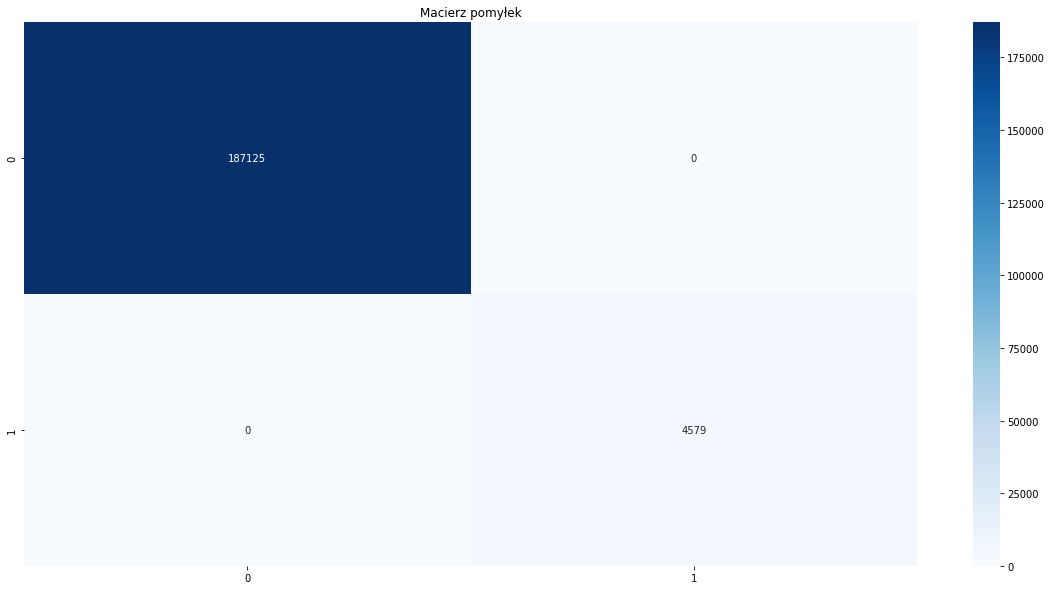

In [59]:
start = time()
forest = RandomForestClassifier(random_state=random_state, n_jobs=6)
forest.fit(neoData.small_x_train, neoData.small_y_train)
print(f'Czas na model: {time() - start}')
evaluate_mulit_feature_model(forest, neoData)

Fitting 2 folds for each of 288 candidates, totalling 576 fits
GridSearchCV searching time = 13.344660405317942 min
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
Metryki modelu: Czulość: 1.0, swoistość: 1.0, Adjusted accuracy=1.0


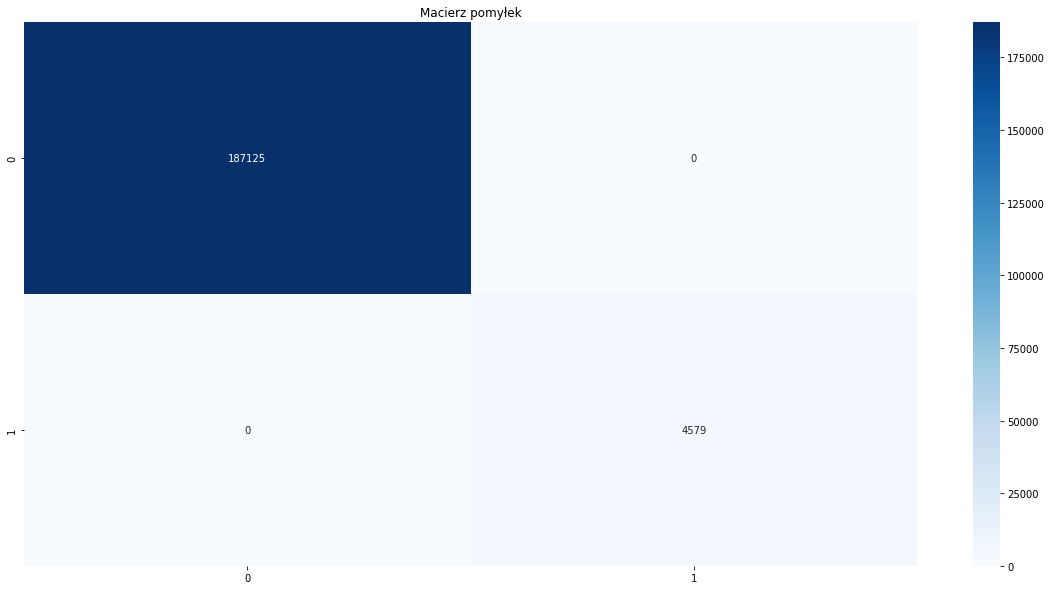

Fitting 2 folds for each of 288 candidates, totalling 576 fits
GridSearchCV searching time = 10.123460737864177 min
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 16, 'n_estimators': 100}
Metryki modelu: Czulość: 0.0, swoistość: 1.0, Adjusted accuracy=0.0


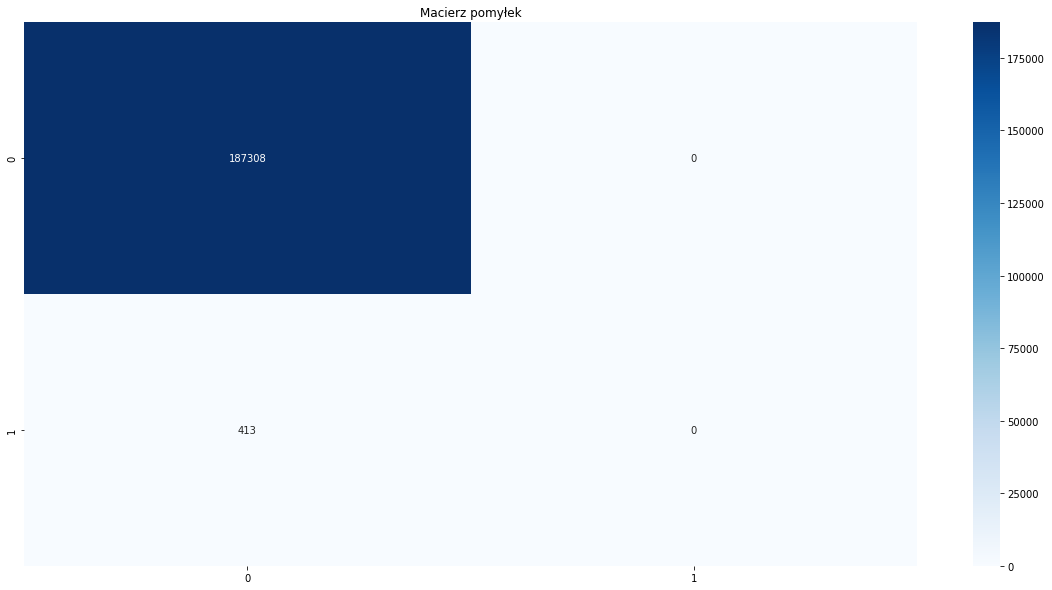

In [153]:
for data in [neoData, phaData]:
    params = {
        'n_estimators': [10, 50, 100],
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 16, 32],
        'min_samples_split': [2, 4, 8, 16],
        'min_samples_leaf': [1, 2, 4, 8],
    }

    forest = RandomForestClassifier()
    grid_searcher = GridSearchCV(forest, params, verbose=3, n_jobs=6, cv=2)
    start = time()
    grid_searcher.fit(data.small_x_train, data.small_y_train)
    print(f'GridSearchCV searching time = {(time() - start) / 60} min')
    print(grid_searcher.best_params_)
    best_model = grid_searcher.best_estimator_
    evaluate_mulit_feature_model(best_model, data)

# Czesc na 5

In [128]:
depths = [2, 6, 10, 14, 18, 20]

In [126]:
start = time()
for _ in range(1):
    my_model = MyRandomForest(criterion='gini', max_depth=2, n_estimators=20)
    my_model.fit(neoData.small_x_train, neoData.small_y_train)
print(time() - start)

123.64491939544678


In [129]:
sk_learn_times = []
my_learn_times = []
sk_predict_times = []
my_predict_times = []
sk_accuracies = []
my_accuracies = []

In [130]:
for depth in depths:
    print(f'Depth: {depth}')
    start = time()
    for _ in range(5):
        my_model = MyRandomForest(criterion='gini', max_depth=depth, n_estimators=20)
        my_model.fit(neoData.small_x_train, neoData.small_y_train)
    my_learn_times.append((time() - start) / 5)

    start = time()
    for _ in range(5):
        sk_model = RandomForestClassifier(criterion='gini', max_depth=depth, n_estimators=20)
        sk_model.fit(neoData.small_x_train, neoData.small_y_train)
    sk_learn_times.append((time() - start) / 5)

    start = time()
    for _ in range(5):
        my_predicts = my_model.predict(neoData.x_test)
    my_predict_times.append((time() - start) / 5)

    start = time()
    for _ in range(5):
        sk_predicts = sk_model.predict(neoData.x_test)
    sk_predict_times.append((time() - start) / 5)

    sk_accuracies.append(balanced_accuracy_score(neoData.y_test, sk_predicts, adjusted=True))
    my_accuracies.append(balanced_accuracy_score(neoData.y_test, my_predicts, adjusted=True))



Depth: 2
Depth: 6
Depth: 10
Depth: 14
Depth: 18
Depth: 20


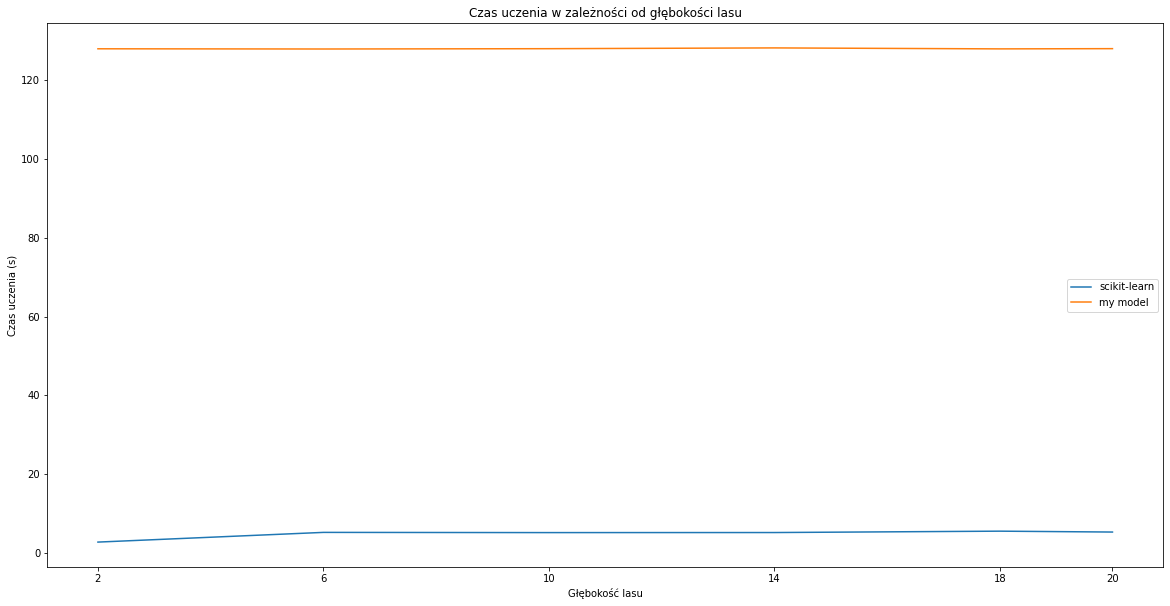

In [131]:
plt.plot(depths, sk_learn_times, label='scikit-learn')
plt.plot(depths, my_learn_times, label='my model')
plt.legend()
plt.title('Czas uczenia w zależności od głębokości lasu')
plt.xlabel('Głębokość lasu')
plt.ylabel('Czas uczenia (s)')
plt.xticks(depths)
plt.show()

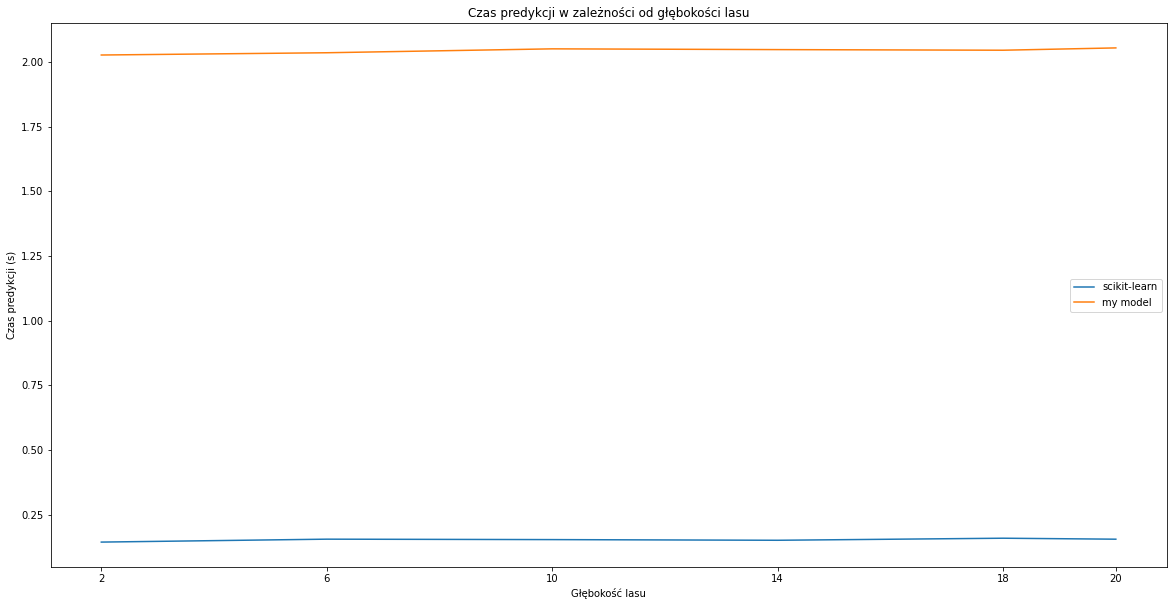

In [132]:
plt.plot(depths, sk_predict_times, label='scikit-learn')
plt.plot(depths, my_predict_times, label='my model')
plt.legend()
plt.title('Czas predykcji w zależności od głębokości lasu')
plt.xlabel('Głębokość lasu')
plt.ylabel('Czas predykcji (s)')
plt.xticks(depths)
plt.show()

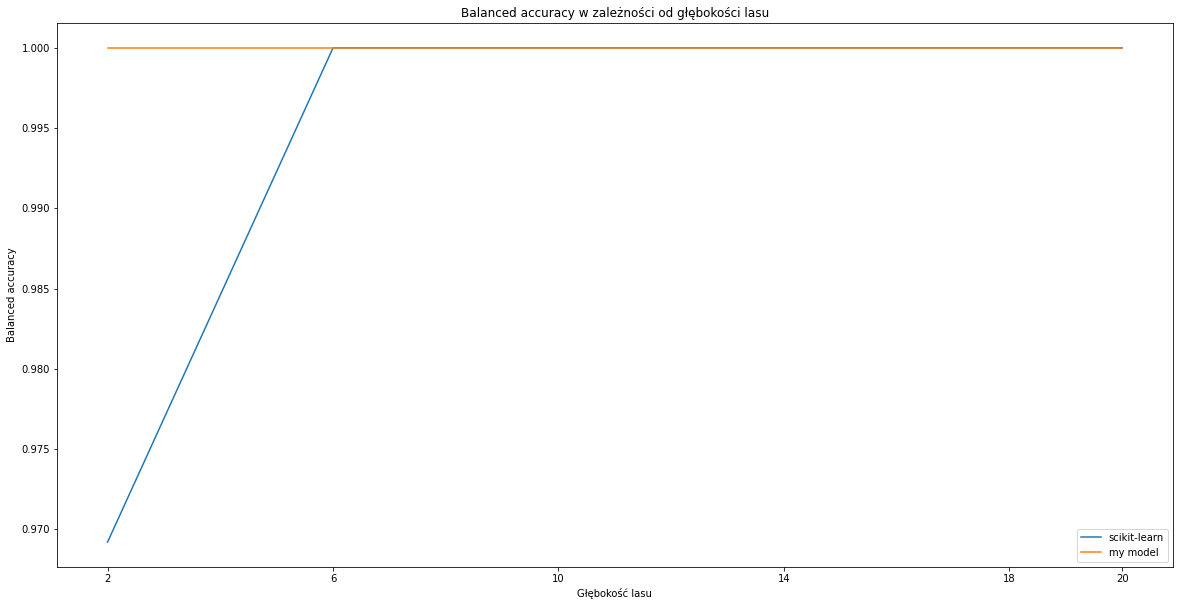

In [133]:
plt.plot(depths, sk_accuracies, label='scikit-learn')
plt.plot(depths, my_accuracies, label='my model')
plt.legend()
plt.title('Balanced accuracy w zależności od głębokości lasu')
plt.xlabel('Głębokość lasu')
plt.ylabel('Balanced accuracy')
plt.xticks(depths)
plt.show()